# Topic Analysis with SpaCy
## Data Pre-processing
Import necessary packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import en_core_web_sm
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import dateutil.parser as dparser
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() #Notebook visualisation enabled
import os
import re
import unicodedata
import en_core_web_md

Read data and exploration

In [2]:
# Load up the files
#path = './DataUCSB/' # Smaller UCSB dataset
#path = './Data/' # larger American Rhetoric dataset
paths = ['./Data/', './NYT/', './WSJ/', './GWB/', './speeches/', './Top10/']

speeches = []

for path in paths:
    list_of_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.txt'):
                list_of_files.append(os.path.join(root,file))
   
    for file in list_of_files:
        with open(file, encoding='utf-8') as f:
            text = f.read()
        f.close()
        speeches.append(text)

#clean out goofy unicode  space characters 
speeches = [unicodedata.normalize("NFKD", speech) for speech in speeches if len(speech)>0 ]
#clean out xa0 space characters
[speech.replace(u'\xa0', '') for speech in speeches]; # ; supresses output
# remove [stuff] in between square brackets
def remove_bracket(text):
    return re.sub(r'(\[[^w]*\]\s)', '',text)
speeches = [remove_bracket(speech) for speech in speeches]
# Clean up whitespace
speeches = [re.sub(r'[\s+]', ' ', speech) for speech in speeches]
print("Total documents:",len(speeches))

Total documents: 744


Step 3: Tokenization and text cleanup

In [3]:
oba_scripts=pd.DataFrame(speeches)
oba_scripts = oba_scripts[0]

In [4]:
#Load SpaCy English Model
nlp = en_core_web_md.load()
#Tags to remove
extags = ['PRON','CCONJ','PUNCT','PART','DET','ADP','NUM','SYM','SPACE']
docs = oba_scripts.apply(nlp)
tokens=[]
#SpaCy tokenization + lemmatization + lowercase
for speech in docs:
    scr_tok = [token.lemma_.lower() for token in speech if token.pos_ not in extags and not token.is_stop and token.is_alpha]
    tokens.append(scr_tok)
data = pd.DataFrame()
data['tokens'] = tokens
data['tokens']


0      [thank, hello, vfw, thank, seat, commander, de...
1      [give, freedom, slave, assure, freedom, free, ...
2      [behalf, great, state, illinois, crossroad, na...
3      [thank, thank, thank, chairman, dean, great, f...
4      [good, morning, morning, send, budget, congres...
                             ...                        
739    [majesty, royal, highnesses, distinguished, me...
740    [thank, seat, family, lose, call, friend, stud...
741    [rare, honor, life, follow, hero, john, lewis,...
742    [give, praise, honor, god, bible, call, hope, ...
743    [hello, america, hello, democrats, year, ago, ...
Name: tokens, Length: 744, dtype: object

## LDA Topic Analysis model and coherence scores

In [5]:
token_dict = Dictionary(data['tokens'])
#Filter out tokens that appear in less than 5 speeches, and tokens that appear in more than 70% of speeches since they are too general. Keep the top 1000 most frequent tokens
token_dict.filter_extremes(no_below=5,no_above=0.5,keep_n=1000)

#Convert token counts into bag of words (BoW) corpus
corpus = [token_dict.doc2bow(speech) for speech in data['tokens']]

In [6]:
#Construct and train unsupervised LDA model + Determine optimal number of topics
umtopics, umscore = [], []
cvtopics, cvscore = [], []
#Compute coherence score using C_umass:
for i in range(3,15,1):
    model = LdaMulticore(corpus=corpus, id2word=token_dict, iterations=50, num_topics=i, workers=4, passes=10, random_state=47)
    #LdamultiCore uses multiple cores to speed up model training, use with caution if you have a weaker PC! (Find your max number of cores with ctrl+shift+esc, under CPU)
    cm = CoherenceModel(model=model, corpus=corpus, dictionary=token_dict, coherence='u_mass')

    umtopics.append(i)
    umscore.append(cm.get_coherence())
#Compute coherence score using C_v: 
for i in range (3,15,1):
    model = LdaMulticore(corpus=corpus, id2word=token_dict, iterations=10, num_topics=i, workers = 4, passes=10, random_state=47)
    cm = CoherenceModel(model=model, texts = data['tokens'], corpus=corpus, dictionary=token_dict, coherence='c_v')

    cvtopics.append(i)
    cvscore.append(cm.get_coherence())
#The difference in coherence score measures is the method in which the text is segmented and probability is calculated


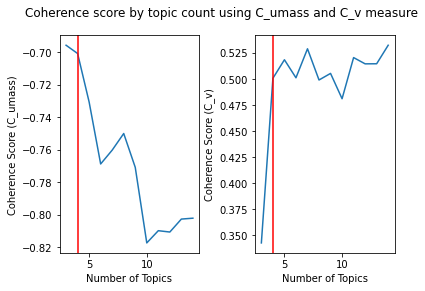

In [7]:
#Adjustable threshold for visualising with red vertical lines
threshold=4
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Coherence score by topic count using C_umass and C_v measure')
fig.subplots_adjust(wspace=0.4)

ax1.plot(umtopics,umscore)
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score (C_umass)')
ax1.axvline(x=threshold,c='red')

ax2.plot(cvtopics,cvscore)
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Coherence Score (C_v)')
ax2.axvline(x=threshold,c='red')
#For both scores, higher values are better. Choice of topic count is subjective, but both scores must be taken into account.
plt.show()

Based on the coherence scores, best is usually the max. In this case we choose to select 6 topics, since it is the max value for the C_v score while also having a relatively higher C_umass score.

In [8]:
#Construct final model with 4 topics (Increase iterations and passes because it is the final model)
finalmodel = LdaMulticore(corpus=corpus, id2word=token_dict, iterations=100, num_topics=9, workers = 4, passes=100, random_state=47)

finalmodel.print_topics()

[(0,
  '0.032*"energy" + 0.021*"oil" + 0.015*"clean" + 0.012*"climate" + 0.010*"plan" + 0.009*"industry" + 0.009*"space" + 0.009*"company" + 0.009*"global" + 0.008*"develop"'),
 (1,
  '0.063*"nuclear" + 0.056*"iran" + 0.039*"weapon" + 0.032*"israel" + 0.022*"deal" + 0.020*"international" + 0.016*"sanction" + 0.013*"program" + 0.011*"regime" + 0.010*"peace"'),
 (2,
  '0.019*"intelligence" + 0.017*"information" + 0.014*"protect" + 0.014*"national" + 0.013*"court" + 0.010*"review" + 0.010*"terrorist" + 0.009*"administration" + 0.009*"justice" + 0.009*"system"'),
 (3,
  '0.031*"health" + 0.030*"care" + 0.022*"tax" + 0.020*"insurance" + 0.016*"pay" + 0.014*"cut" + 0.013*"plan" + 0.012*"reform" + 0.011*"bill" + 0.011*"business"'),
 (4,
  '0.013*"peace" + 0.012*"human" + 0.012*"democracy" + 0.011*"freedom" + 0.009*"progress" + 0.008*"free" + 0.008*"region" + 0.007*"global" + 0.007*"citizen" + 0.007*"africa"'),
 (5,
  '0.020*"business" + 0.013*"school" + 0.012*"student" + 0.012*"education" + 0

In [9]:
finalmodel.get_topics() # shape: num_topics x vocabulary_size

array([[1.0949839e-03, 3.1652470e-04, 9.4115443e-04, ..., 5.4462221e-06,
        5.5266460e-06, 7.3807879e-04],
       [1.7173205e-03, 7.4915483e-06, 4.9176267e-03, ..., 1.2829450e-04,
        7.5171406e-06, 3.7115888e-04],
       [2.2182479e-03, 1.1366716e-03, 7.9031242e-04, ..., 6.0718248e-06,
        7.9863379e-04, 5.7426264e-04],
       ...,
       [3.7583283e-03, 6.8135280e-04, 4.1011795e-06, ..., 9.5725723e-04,
        4.0000073e-06, 4.8901711e-04],
       [1.5897113e-03, 1.8255290e-06, 1.3654119e-03, ..., 3.1098130e-04,
        3.8793773e-06, 1.3103370e-04],
       [8.5190131e-04, 3.2382077e-04, 1.5073243e-03, ..., 1.2915278e-03,
        2.9632756e-06, 1.8410213e-04]], dtype=float32)

In [10]:
#Checking for first speech - DNC keynote speech 2004
finalmodel[corpus][0]
#Main topic is Topic 3, which seems to be some sort of mixed bag. The speech itself covers his personal life and the democratic party.

[(1, 0.013998536),
 (3, 0.2005018),
 (5, 0.10192279),
 (7, 0.13320048),
 (8, 0.5498218)]

What follows is an advanced visualisation of the topics. Each circle represents a topic and upon hovering over a circle, the bars on the right illustrate the frequency of words that appear in the topic. Closer circles are more related, which is logical since political arguments correlate highly with voting campaigns. Visualisation of circles is done through PCA dimension reduction.

In [11]:
#       vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
lda_display = pyLDAvis.gensim_models.prepare(topic_model=finalmodel, corpus=corpus, dictionary=token_dict)
pyLDAvis.display(lda_display)

TypeError: drop() takes from 1 to 2 positional arguments but 3 were given

In [24]:
columns = list(dict(token_dict).values())

In [95]:
# num topics x vocab size, here 9x1000
topic_vals = pd.DataFrame(finalmodel.get_topics(), columns=columns)
topic_vals.shape

(9, 1000)

In [52]:
topic_by_doc=list(finalmodel[corpus])

In [85]:
#[doc][topic][0-id] or [1-value]
doc_topics = []
for doc_num in range(len(topic_by_doc)):
    topics_for_doc = [0] * len(finalmodel.print_topics())
    for i in range(len(finalmodel.print_topics())):
        if (i < len(topic_by_doc[doc_num])):
            topics_for_doc[topic_by_doc[doc_num][i][0]]=topic_by_doc[doc_num][i][1]
    doc_topics.append(topics_for_doc);

In [93]:
# doc_topics is num_docs x num_topics or 744 rows x 9 cols
doc_topics = pd.DataFrame(doc_topics)
doc_topics.shape

(744, 9)

In [96]:
docs_words = doc_topics.dot(topic_vals)

In [110]:
# sum for each document should by 1-ish
docs_words.sum(axis=1) # 0-rows, 1-cols

0      0.999445
1      0.996525
2      0.998966
3      0.999773
4      0.998328
         ...   
739    0.999341
740    0.998194
741    0.999157
742    0.998424
743    0.999729
Length: 744, dtype: float64